# Important Frequencies Selection

## Import Libraries and seed
Import the necessary libraries for data processing, model building, training, and evaluation. Adding a seed ensures reproducibility by making sure that the random number generation is consistent across different runs.

In [1]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
import matplotlib.pyplot as plt
import graphviz 
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import export_graphviz
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier

from scipy.stats import zscore

# import wandb

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    return seed

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Set seed for reproducibility
seed = set_seed(42)


Using device: cpu


In [2]:
def load_data_from_directory(input_path):
    data_frames = []
    for file in os.listdir(input_path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(input_path, file), delimiter=';', header=0)
            data_frames.append(df)
    data = pd.concat(data_frames, ignore_index=True)

    return data

## Preprocessing Data
Define a function to preprocess the data. This includes encoding categorical labels and standardizing the features.

In [3]:
def calculate_averages_and_dispersion(df, data_percentage):

    results = []
    for (sample, freq), group in df.groupby(['Sample', 'Frequency (GHz)']):
        window_size = max(1, int(len(group) * data_percentage / 100))
        # print(f"Processing sample: {sample}, frequency: {freq} with window size: {window_size}")
        for start in range(0, len(group), window_size):
            window_data = group.iloc[start:start + window_size]
            mean_values = window_data[['LG (mV)', 'HG (mV)']].mean()
            std_deviation_values = window_data[['LG (mV)', 'HG (mV)']].std()
            results.append({
                'Frequency (GHz)': freq,
                'LG (mV) mean': mean_values['LG (mV)'],
                'HG (mV) mean': mean_values['HG (mV)'],
                'LG (mV) std deviation': std_deviation_values['LG (mV)'],
                'HG (mV) std deviation': std_deviation_values['HG (mV)'],
                # 'Thickness (mm)': window_data['Thickness (mm)'].iloc[0], ## COMMENT
                'Sample': sample,
            })
    results_df = pd.DataFrame(results)
    # results_df.to_csv(output_file, sep=';', index=False)
    # print(f"Processed {input_file} and saved to {output_file}")
    # print(results_df)
    return results_df

## Pivoting Frequency values to columns

In [4]:
def freq_as_variable(df, data_percentage):
    '''Modify df to have Frequency values (100,110,120 and so on) as input variables in the columns'''

    # Remove Thickness column
    if 'Thickness (mm)' in df.columns:
        df = df.drop(columns=['Thickness (mm)'])

    if data_percentage > 0:
        # 1s window_size 100/27s = 3.7% of the data is used for each window
        df_window = calculate_averages_and_dispersion(df, data_percentage) 

        # Add a unique identifier column to avoid duplicate entries in the index
        df_window['unique_id'] = df_window.groupby(['Sample', 'Frequency (GHz)']).cumcount()

        # Pivot the DataFrame to wide format
        df_pivot = df_window.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')

        # Flatten the MultiIndex columns - Ordered by Frequency + (HG mean, HG std deviation, LG mean, LG std deviation)
        df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]

        # Drop columns with all NaN values
        df_pivot = df_pivot.dropna(axis=1, how='all')

        # Reset index to make 'Sample' and 'unique_id' columns again
        df_pivot = df_pivot.reset_index()

        # Remove 'unique_id' column
        df_pivot = df_pivot.drop(columns=['unique_id'])
    else:
        # If data_percentage is 0, do not calculate mean and std deviation, use the original data
        df['unique_id'] = df.groupby(['Sample', 'Frequency (GHz)']).cumcount()
        df_pivot = df.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')
        df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]
        df_pivot = df_pivot.dropna(axis=1, how='all')
        df_pivot = df_pivot.reset_index()
        df_pivot = df_pivot.drop(columns=['unique_id'])

    # Optional - Sort the columns if needed
    df_pivot = df_pivot.reindex(sorted(df_pivot.columns), axis=1)

    return df_pivot

In [5]:
# Load the data from the directory
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_4_plastics/processed/'
# input_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test'
# input_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_4_plastics/processed/'

df = load_data_from_directory(input_path)

df = pd.concat([df[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df[['Sample']]], axis=1)

df_ori = df.copy()

# Find if value samples have '_' in the name and remove everything after '_' 
# df['Sample'] = df['Sample'].str.split('_').str[0]
df['Sample'] = df['Sample'].str[0]

df.head(10)


,Frequency (GHz),LG (mV),HG (mV),Sample
0,100.0,0.671469,20.815529,B
1,100.0,-0.305213,22.463679,B
2,100.0,-0.122085,17.458186,B
3,100.0,0.122085,20.662922,B
4,100.0,-0.061043,22.646807,B
5,100.0,0.396777,17.946526,B
6,100.0,-0.732511,23.989744,B
7,100.0,0.671469,20.815529,B
8,100.0,0.183128,17.641313,B
9,100.0,-0.122085,15.901599,B


## Balance Dataset

C:\Users\Danim\AppData\Local\Temp\ipykernel_29776\3669193858.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


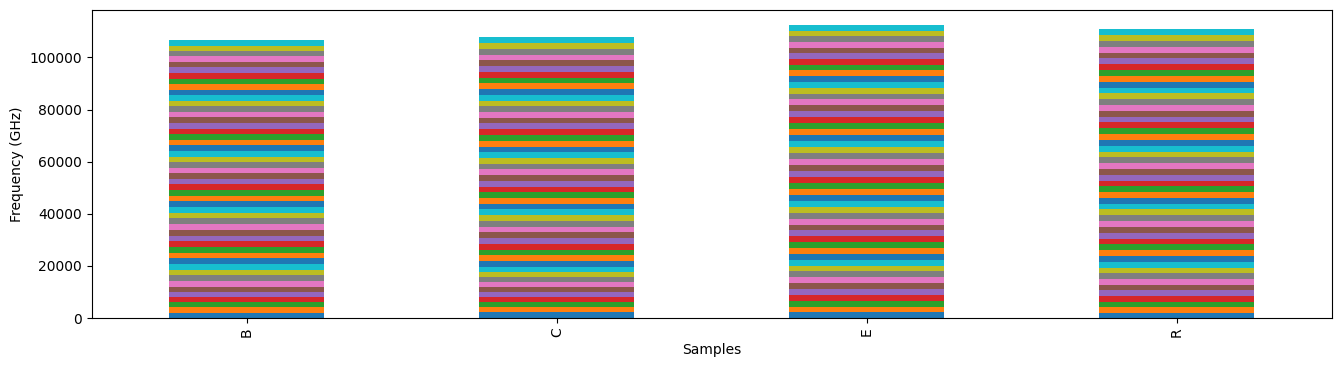

Mean value: 2190


C:\Users\Danim\AppData\Local\Temp\ipykernel_29776\3669193858.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


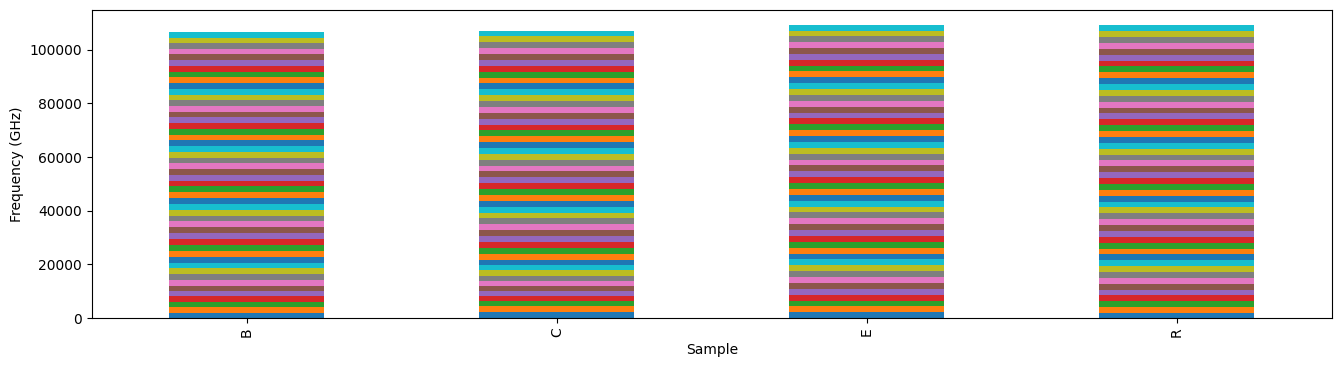

In [6]:
# Number of samples per frequency and Sample
bx = df.groupby(['Sample', 'Frequency (GHz)']).size().unstack().plot.bar(figsize=(16, 4), stacked=True)
bx.set_xlabel('Samples')
bx.set_ylabel('Frequency (GHz)')
plt.tight_layout()
#no legend
bx.get_legend().remove()
plt.show()

# Balance the data by taking the mode of samples per frequency
mean= int(df.groupby(['Sample', 'Frequency (GHz)']).size().mean())
print(f'Mean value: {mean}')


# Function to reduce samples to the mean value
def reduce_to_mean(df, sample, frequency, mean):
    # Filter the DataFrame for the specific sample and frequency
    freq_df = df[(df['Sample'] == sample) & (df['Frequency (GHz)'] == frequency)]
    # If the number of samples is greater than the mean, sample down to the mean
    if len(freq_df) > mean:
        return freq_df.sample(n=mean, random_state=42)
    return freq_df

# Apply the function to reduce samples for each combination of Sample and Frequency (GHz)
balanced_data = []
for (sample, frequency), group in df.groupby(['Sample', 'Frequency (GHz)']):
    balanced_data.append(reduce_to_mean(df, sample, frequency, mean))

# Combine the balanced samples into a single DataFrame
df_balanced = pd.concat(balanced_data)

bx = df_balanced.groupby(['Sample', 'Frequency (GHz)']).size().unstack().plot.bar(figsize=(16, 4), stacked=True)
bx.set_ylabel('Frequency (GHz)')
plt.tight_layout()
# legend small
bx.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#remove legend
bx.get_legend().remove()
plt.show()

## Data Feature Transformation Visualization

In [ ]:
# Group by 'Sample' and 'Frequency (GHz)' and calculate the mean and standard deviation
mean_std_df = df_ori.groupby(['Sample', 'Frequency (GHz)']).agg(
    LG_mean=('LG (mV)', 'mean'),
    LG_std=('LG (mV)', 'std'),
    HG_mean=('HG (mV)', 'mean'),
    HG_std=('HG (mV)', 'std')
).reset_index()

print(mean_std_df)

# Substract the HG mean value of the previous frequency 
# Create a new DataFrame to store the differences
diff_df = mean_std_df.copy()

# Calculate the difference in HG and LGmean values between consecutive frequencies for each sample
diff_df['HG_mean_diff'] = diff_df.groupby('Sample')['HG_mean'].diff()
diff_df['LG_mean_diff'] = diff_df.groupby('Sample')['LG_mean'].diff()

# Rows where the difference could not be calculated are equal to 0
diff_df['HG_mean_diff'] = diff_df['HG_mean_diff'].fillna(0)
diff_df['LG_mean_diff'] = diff_df['LG_mean_diff'].fillna(0)

print(diff_df)


# Plot the difference in HG mean values for each sample
unique_samples = diff_df['Sample'].unique()

fig, axes = plt.subplots((len(unique_samples) + 3) // 4, 4, figsize=(20, 5 * ((len(unique_samples) + 3) // 4)), sharex=True)

for i, sample in enumerate(unique_samples):
    row, col = divmod(i, 4)
    sample_df = diff_df[diff_df['Sample'] == sample]
    sample_df.plot(x='Frequency (GHz)', y='HG_mean_diff', ax=axes[row, col], label=sample)
    axes[row, col].set_ylabel('HG Mean Difference')
    axes[row, col].legend(title='Sample')
    axes[row, col].xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Ensure integer ticks
    axes[row, col].xaxis.set_major_locator(plt.MultipleLocator(5))  # Add more ticks
    axes[row, col].grid(True, alpha=0.5)  # Add grid with transparency

for j in range(i + 1, len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

axes[-1, 0].set_xlabel('Frequency (GHz)')
plt.tight_layout()
plt.show()


# Plot the difference in HG mean values for each group of samples starting with the same letter
unique_sample_groups = sorted(set(sample[0] for sample in unique_samples))

# Calculate the number of rows needed
n_rows = len(unique_sample_groups)

fig, axes = plt.subplots(n_rows, 1, figsize=(20, 5 * n_rows), sharex=True)

# Ensure axes is always a 1D array
if n_rows == 1:
    axes = np.array([axes])

for i, group in enumerate(unique_sample_groups):
    group_samples = [sample for sample in unique_samples if sample.startswith(group)]
    for sample in group_samples:
        sample_df = diff_df[diff_df['Sample'] == sample]
        sample_df.plot(x='Frequency (GHz)', y='HG_mean_diff', ax=axes[i], label=sample)
    axes[i].set_ylabel('HG Mean Difference')
    axes[i].legend(title='Sample')
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Ensure integer ticks
    axes[i].xaxis.set_major_locator(plt.MultipleLocator(5))  # Add more ticks
    axes[i].grid(True, alpha=0.5)  # Add grid with transparency

axes[-1].set_xlabel('Frequency (GHz)')
plt.tight_layout()
plt.show()


## Sample a test set

In [7]:
df_train = df_balanced.copy()

test_percentage = 0.2

# # Shuffle the data
# df_train = df_train.sample(frac=1, random_state=42)

train_set, test_set = train_test_split(df_train, test_size=test_percentage, random_state=42) 

# stratify=df['Sample'] to keep the same proportion of samples in the train and test set

train_set.head()




,Frequency (GHz),LG (mV),HG (mV),Sample
32941,200.0,18.190697,-0.671476,B
376329,480.0,-0.518862,122.665132,R
271557,590.0,-0.244170,22.555243,E
361844,230.0,1.617629,26.400936,R
219330,180.0,19.533634,0.030524,E


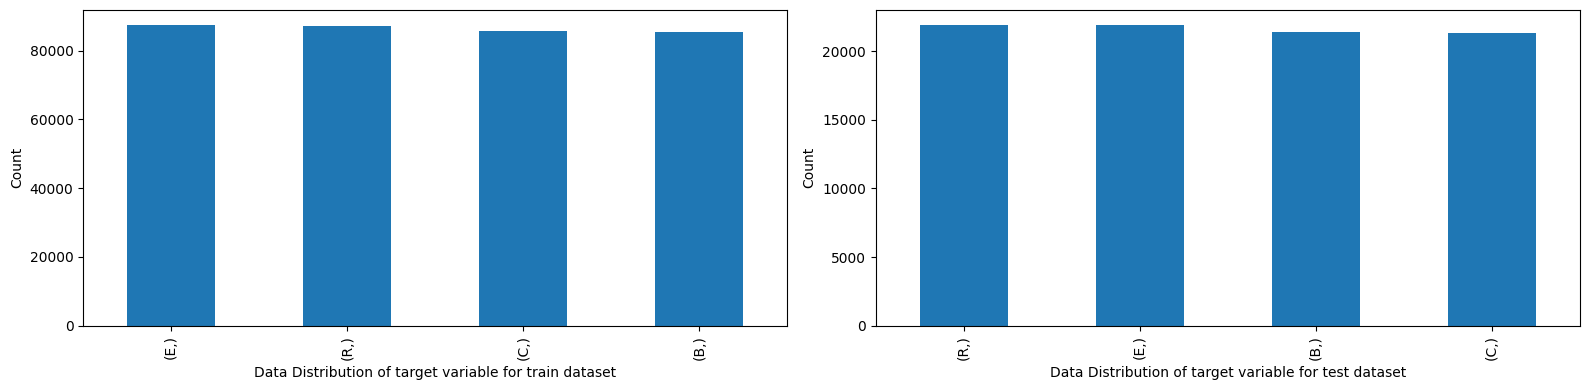

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# Plot train set
train_set[['Sample']].value_counts().plot.bar(ax=ax[0], legend=False)
ax[0].set_xlabel('Data Distribution of target variable for train dataset')
ax[0].set_ylabel('Count')

# Plot test set
test_set[['Sample']].value_counts().plot.bar(ax=ax[1], legend=False)
ax[1].set_xlabel('Data Distribution of target variable for test dataset')
ax[1].set_ylabel('Count')

plt.tight_layout() 
plt.show()

In [9]:
train_ex = train_set.copy()

# train_ex.info()
# train_ex.describe()

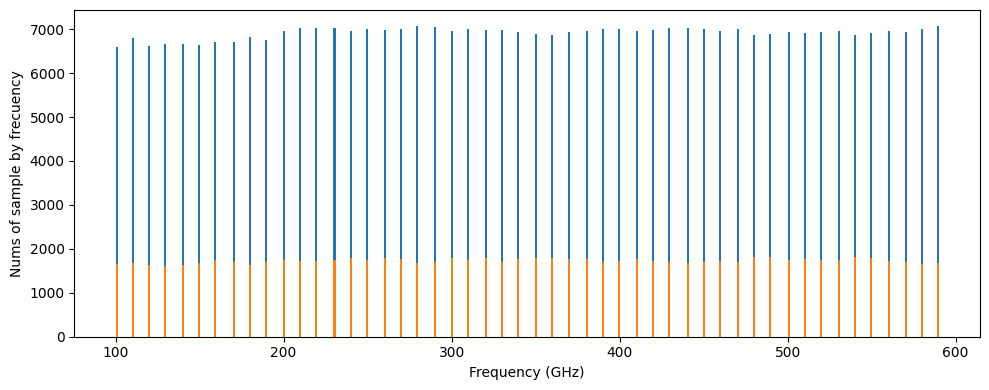

In [10]:
ax = train_ex['Frequency (GHz)'].plot.hist(figsize=(10, 4), bins=408)
ax = test_set['Frequency (GHz)'].plot.hist(ax=ax, bins=408)
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Nums of sample by frecuency')
plt.tight_layout()
plt.show()

In [11]:
# Calculate the percentage of data used for each window
time_window_s = 0.1
stabilised_time_s = 48
data_percentage = (100/(stabilised_time_s*(1-test_percentage))) * time_window_s
data_percentage_test = (100/(stabilised_time_s*(test_percentage))) * time_window_s

# data_percentage = 100
# data_percentage_test = 100

print(f"Data percentage: {data_percentage}%")
print(f"Data percentage test: {data_percentage_test}%")

# Load just a % of the data
# df_sample = train_set.sample(frac=0.02, random_state=42)


# Introduce Frequency values as input variables
train_set_test = freq_as_variable(train_set, data_percentage)
test_set_test = freq_as_variable(test_set, data_percentage_test)


# If a row has any NaN value, remove that row
train_set_test = train_set_test.dropna()
test_set_test = test_set_test.dropna()

## Save the processed data to a CSV file

# output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
# output_path_test = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'
# output_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
# output_path_test = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'

# train_set_test.to_csv(output_path, sep = ';', index=False)
# test_set_test.to_csv(output_path_test, sep = ';', index=False)




Data percentage: 0.26041666666666663%
Data percentage test: 1.0416666666666665%


# Prepare Training Data
## Split the data into X and y


In [138]:
def preprocess_data(df, labels, freqs, drop_sample=True, eliminate_std_dev=False, eliminate_LG=False):
    # Reduce number of different samples for testing
    X_ = df[df['Sample'].isin(labels)]

    y_ = X_['Sample']

    if drop_sample:
        X_ = X_.drop(columns=['Sample'])
        
    if freqs:
        # Subset of specific frequencies to use as input features (or without mean)
        columns = [f'{freq}.0 HG (mV) mean' for freq in freqs] + \
                  [f'{freq}.0 LG (mV) mean' for freq in freqs] + \
                  [f'{freq}.0 HG (mV)' for freq in freqs] + \
                  [f'{freq}.0 LG (mV)' for freq in freqs] + \
                  [f'{freq}.0 HG (mV) std deviation' for freq in freqs] + \
                  [f'{freq}.0 LG (mV) std deviation' for freq in freqs] + \
                  ['Sample']


        # Filter columns that exist in X_
        existing_columns = [col for col in columns if col in X_.columns]

        # Check if existing_columns is empty
        if not existing_columns:
            print("No matching columns found in X_.")
        else:
            X_ = X_[existing_columns]

        # Sort columns by frequency value
        X_ = X_.reindex(sorted(X_.columns), axis=1)

    if eliminate_std_dev:
        # Eliminate std dev columns from the input features
        X_ = X_.drop(columns=[col for col in X_.columns if 'std deviation' in col])

    if eliminate_LG:
        # Eliminate LG columns from the input features
        X_ = X_.drop(columns=[col for col in X_.columns if 'LG' in col])

    return X_, y_


In [16]:
# Subset of specific Samples to use in the training
# labels = ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1', 'K1', 'L1', 'M1', 'N1', 'REF']
# labels = ['B1', 'C1', 'E3', 'REF']
labels = ['B', 'C', 'E', 'R']

# Subset of specific frequencies to use as input features, If freqs = [] then all frequencies are used
# freqs = [200,210,230,250,270,280,290,300,310,320,330,360]
# freqs = [200,210,230,250,270,280,290,300,310,320,330,360,340,350,370,380,390,400,410,430,440]
freqs = [250,300,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540]
freqs = [310]

# Count number of frequencies
print(f'freqs number: {len(freqs)}')

# freqs = []

# # Shuffle the data
# train_set_test = train_set_test.sample(frac=1, random_state=42)
# test_set_test = test_set_test.sample(frac=1, random_state=42)

X_train, y_train = preprocess_data(train_set_test, labels, freqs, drop_sample=False, eliminate_std_dev=False) 
X_test, y_test = preprocess_data(test_set_test, labels, freqs, drop_sample=False, eliminate_std_dev=False)

# Encode the target variable if it's categorical
if y_train.dtype == 'object':
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)

if y_test.dtype == 'object':
    y_test = le.transform(y_test)


# le is the fitted LabelEncoder - Saving Encoder
joblib.dump(le, 'label_encoder.pkl')

# # Standardize the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Remove sample columns
X_train = X_train.drop(columns=['Sample'])
X_test = X_test.drop(columns=['Sample'])

print(X_train)


freqs number: 1
      310.0 HG (mV) mean  310.0 HG (mV) std deviation  310.0 LG (mV) mean  \
0               0.358628                     0.362311            1.899951   
1               0.373893                     0.292080            2.403553   
2              -0.076312                     0.457138            2.548529   
3               0.106822                     0.235758            2.624832   
4              -0.160244                     0.169691            2.296728   
...                  ...                          ...                 ...   
1782            0.213635                     0.030518            2.309445   
1783            0.386598                     0.216530            2.553616   
1784            0.061043                     0.291142            2.065275   
1785            0.071214                     0.474145            3.225084   
1786           -0.030504                     0.455784            2.706222   

      310.0 LG (mV) std deviation  
0                      

In [ ]:
## Data transformation 
# 1) Inputs: xt - (xt-1) --First-order differences
# 2) Inputs: (xt/(xt-1)) - 1 --Escalado relativo

In [ ]:
#### TBD ####
# FEATURE TRANSFORMATIONS
# feature engineering transformation with autofeat
# from autofeat import AutoFeatClassifier
# from autofeat import AutoFeatRegressor

### Principal Component Analysis

In [ ]:
# Apply PCA
n_components = 5
pca = PCA(n_components)  # Reduce to 2 components for visualization
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
y_pca = y_train

# Plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.step(range(1, n_components+1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='cumulative explained variance', color='orange')
plt.fill_between(range(1, n_components+1), np.cumsum(pca.explained_variance_ratio_), step='mid', alpha=0.2, color='orange')
plt.bar(range(1, n_components+1), pca.explained_variance_ratio_, alpha=1.0, align='center', label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


### VISUALIZATION ###
# Plot the PCA components (first two components for visualization)
plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_pca, cmap = 'tab20',
                      edgecolor='k', s=25)
# Produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# Show a class label on the data points (just one label per class in total)
offset = 10
for i, label in enumerate(labels):
    plt.text(X_train_pca[y_pca == i, 0].mean() , X_train_pca[y_pca == i, 1].mean() + offset, label,
             ha='center', va='center', size=8, bbox=dict(facecolor='w', alpha=0.6))


plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('PCA of Training Data')


plt.show()


# Show how the principal components are related to the original features
# Create a DataFrame with the PCA components
components = pd.DataFrame(pca.components_, columns=X_train.columns)
# Transpose the DataFrame
components = components.T
# Display the highest and lowest n variables of the first 3 components
n= 10
for i in range(n_components):
    print(f"Component {i+1}:")
    print(components[i].nlargest(n), '\n')
    print(components[i].nsmallest(n), '\n')


## NON PCA VISUALIZATION ##
# Choose specific variables for visualization
var1 = '410.0 HG (mV)'
var2 = '360.0 HG (mV)'
# var2 = '320.0 HG (mV) std deviation'

try:
    X_train[var1].describe()
except Exception as e:
    var1 = f'{var1} mean'
    var2 = f'{var2} mean'

# Plot the chosen input variables for visualization
plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_train[var1], X_train[var2], c=y_train, cmap='tab20',
                      edgecolor='k', s=25)
# Produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# Show a class label on the data points (just one label per class in total)
offset = 0
unique_labels = np.unique(y_train)
for i, label in enumerate(unique_labels):
    plt.text(X_train[y_train == label][var1].mean(), X_train[y_train == label][var2].mean() + offset, 
             labels[label], ha='center', va='center', size=8, bbox=dict(facecolor='w', alpha=0.6))

plt.xlabel(var1)
plt.ylabel(var2)
plt.title('Scatter Plot of Chosen Input Variables')

plt.show()



In [13]:
# Model Parameters
input_size = X_train.shape[1]
output_size = len(np.unique(y_train))
seed = set_seed(42)

input_size, output_size

X_train.head(5)


NameError: name 'X_train' is not defined

### Define Models
- Random Forest
- Naive-Bayes
- Logistic Regression
- Gradient Boosting

In [145]:
def random_forest_model(X_train, y_train, seed):
    rf_model = RandomForestClassifier(random_state=seed)
    rf_model.fit(X_train, y_train)
    return rf_model

def naive_bayes_model(X_train, y_train):
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    return nb_model

def logistic_regression_model(X_train, y_train, seed):
    lr_model = LogisticRegression(max_iter=10000, random_state=seed)
    lr_model.fit(X_train, y_train)
    return lr_model

def gradient_boosting_model(X_train, y_train, seed):
    gb_model = GradientBoostingClassifier(n_estimators=10, random_state=seed)
    gb_model.fit(X_train, y_train)
    return gb_model

### Train all Models

In [25]:
def train_models(X_train, y_train, seed):
    rf_model = random_forest_model(X_train, y_train, seed)
    nb_model = naive_bayes_model(X_train, y_train)
    lr_model = logistic_regression_model(X_train, y_train, seed)
    gb_model = gradient_boosting_model(X_train, y_train, seed)
    return rf_model, nb_model, lr_model, gb_model

def save_models(rf_model, nb_model, lr_model, gb_model):
    joblib.dump(rf_model, 'random_forest_model.pkl')
    joblib.dump(nb_model, 'naive_bayes_model.pkl')
    joblib.dump(lr_model, 'logistic_regression_model.pkl')
    joblib.dump(gb_model, 'gradient_boosting_model.pkl')

# # Train the models
# rf_model, nb_model, lr_model, gb_model = train_models(X_train, y_train, seed)

In [14]:
# Function to apply confidence threshold
def apply_confidence_threshold(probabilities, threshold=0.5):
    max_probs = np.max(probabilities, axis=1)
    predictions = np.argmax(probabilities, axis=1)
    # Replace predictions with -1 (unknown) where confidence is below threshold
    predictions[max_probs < threshold] = -1
    return predictions, max_probs


In [120]:
def save_model_results(models, data, accuracies, precisions, recalls, f1_scores, predictions, n_features, freqs, 
                      csv_path='comparison_results.csv', verbose = 0):
    
    # Determine test number
    if os.path.exists(csv_path):
        existing_results = pd.read_csv(csv_path, sep=';')
        current_test = existing_results['Test'].max() + 1
    else:
        current_test = 1

    # Create results DataFrame
    results_df = pd.DataFrame({
        'Test': [current_test] * len(models),
        'Data': [data] * len(models),
        'Accuracy': accuracies,
        'Precision': precisions,
        'Recall': recalls,
        'F1-Score': f1_scores,
        'Predictions': predictions,
        'Algorithm': models,
        'Num_Features': [n_features] * len(models),
        'Num Frequencies': [len(freqs)] * len(models),
        'Frequencies': [', '.join([f"{freq:.0f}" for freq in freqs])] * len(models)
    })

    # Format float columns
    float_columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    results_df[float_columns] = results_df[float_columns].round(4)

    # Append or create results file
    if os.path.exists(csv_path):
        updated_results = pd.concat([existing_results, results_df], ignore_index=True)
    else:
        updated_results = results_df

    # Save updated results
    updated_results.to_csv(csv_path, index=False, sep=';')

    if verbose == 1 or verbose == 2:
        print(f"\nTest #{current_test} Results:")
        print(results_df)
    if verbose == 2:
        print("\nAll Results:")
        print(updated_results)
    
    return updated_results

In [135]:
def evaluate_models(y_test, y_pred, verbose = 0):
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    predictions_list = []

    for i, y_pred_i in enumerate(y_pred):
        accuracy = accuracy_score(y_test, y_pred_i)
        precision = precision_score(y_test, y_pred_i, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred_i, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred_i, average='weighted', zero_division=0)

        print(f"Model {i+1} - Accuracy: {accuracy}")
        print(f"Model {i+1} - Precision: {precision}")
        print(f"Model {i+1} - Recall: {recall}")
        print(f"Model {i+1} - F1: {f1}")

        if verbose == 2:
            # Classification report
            print(f"Model {i+1} - Classification Report:\n", classification_report(y_test, y_pred_i), '\n')

        # Predictions made per class with its label encoded value
        predictions = dict(sorted(Counter(y_pred_i).items()))
        
        if verbose == 1 or verbose == 2:
            print(f"Model {i+1} - Predictions: {predictions}\n")

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        predictions_list.append(predictions)

    return accuracies, precisions, recalls, f1_scores, predictions_list

In [17]:
def get_feature_importances(rf_model, lr_model, gb_model, nb_model, X_train, y_train, seed, plot=False, n=30):
    feature_names = X_train.columns

    # Random Forest feature importances
    rf_feature_importances = rf_model.feature_importances_
    rf_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_feature_importances})
    rf_feature_importances_df = rf_feature_importances_df.sort_values('Importance', ascending=False)

    # Logistic Regression feature importances
    lr_feature_importances = lr_model.coef_[0]
    lr_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': lr_feature_importances})
    lr_feature_importances_df = lr_feature_importances_df.sort_values('Importance', ascending=False)

    # Gradient Boosting feature importances
    gb_feature_importances = gb_model.feature_importances_
    gb_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': gb_feature_importances})
    gb_feature_importances_df = gb_feature_importances_df.sort_values('Importance', ascending=False)

    # Naive Bayes permutation importance
    result = permutation_importance(nb_model, X_train, y_train, n_repeats=5, random_state=seed, n_jobs=1)
    sorted_idx = result.importances_mean.argsort()[::-1]
    nb_feature_importances_df = pd.DataFrame({'Feature': feature_names[sorted_idx], 'Importance': result.importances_mean[sorted_idx]})

    if plot:
        # Font size
        plt.rcParams.update({'font.size': 6})

        # Plot the feature importances
        plt.figure(figsize=(20, 10))
        plt.barh(rf_feature_importances_df['Feature'][:n], rf_feature_importances_df['Importance'][:n])
        plt.xlabel('Importance')
        plt.title('Random Forest Feature Importances')
        plt.show()

        plt.figure(figsize=(20, 10))
        plt.barh(lr_feature_importances_df['Feature'][:n], lr_feature_importances_df['Importance'][:n])
        plt.xlabel('Importance')
        plt.title('Logistic Regression Feature Importances')
        plt.show()

        plt.figure(figsize=(20, 10))
        plt.barh(gb_feature_importances_df['Feature'][:n], gb_feature_importances_df['Importance'][:n])
        plt.xlabel('Importance')
        plt.title('Gradient Boosting Feature Importances')
        plt.show()

        plt.figure(figsize=(12, 8))
        plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
        plt.xlabel('Permutation Importance')
        plt.title('Naive Bayes Permutation Feature Importance')
        plt.show()

    return rf_feature_importances_df, lr_feature_importances_df, gb_feature_importances_df, nb_feature_importances_df


In [83]:
# Make Predictions

y_pred = []
y_pred.append(rf_model.predict(X_test))
y_pred.append(nb_model.predict(X_test))
y_pred.append(lr_model.predict(X_test))
y_pred.append(gb_model.predict(X_test))

# Call the function
accuracies, precisions, recalls, f1_scores, predictions = evaluate_models(y_test, y_pred, report=False)

# Define model names
models = ['RF', 'NB', 'LR', 'GB']

# # Get feature importance values
# rf_feature_importances_df, lr_feature_importances_df, gb_feature_importances_df, nb_feature_importances_df = get_feature_importances(
#     rf_model, lr_model, gb_model, nb_model, X_train, y_train, seed, plot=False, n=30)

##TBD 
# - ADD FEATURE IMPORTANCE TO CSV - HOW?

updated_results = save_model_results(
    models=models,
    accuracies=accuracies,
    precisions=precisions,
    recalls=recalls,
    f1_scores=f1_scores,
    predictions=predictions,
    n_features=X_train.shape[1],
    freqs=freqs
)


Model 1 - Accuracy: 0.6259541984732825
Model 1 - Precision: 0.6206698928161737
Model 1 - Recall: 0.6259541984732825
Model 1 - F1: 0.6225695201694862
Model 1 - Predictions: {0: 99, 1: 97, 2: 86, 3: 111}

Model 2 - Accuracy: 0.6259541984732825
Model 2 - Precision: 0.617847132080441
Model 2 - Recall: 0.6259541984732825
Model 2 - F1: 0.6197743041487893
Model 2 - Predictions: {0: 78, 1: 94, 2: 105, 3: 116}

Model 3 - Accuracy: 0.6183206106870229
Model 3 - Precision: 0.6026820628783551
Model 3 - Recall: 0.6183206106870229
Model 3 - F1: 0.6059361165036163
Model 3 - Predictions: {0: 66, 1: 98, 2: 110, 3: 119}

Model 4 - Accuracy: 0.6081424936386769
Model 4 - Precision: 0.6095846182771489
Model 4 - Recall: 0.6081424936386769
Model 4 - F1: 0.6076433159997221
Model 4 - Predictions: {0: 84, 1: 94, 2: 113, 3: 102}


Test #4 Results:
   Test Algorithm  Accuracy  Precision  Recall  F1-Score  \
0     4        RF    0.6260     0.6207  0.6260    0.6226   
1     4        NB    0.6260     0.6178  0.6260  

## Threshold for Unknown class

In [ ]:
# Get predictions and probabilities
rf_probs = rf_model.predict_proba(X_test)
nb_probs = nb_model.predict_proba(X_test)
lr_probs = lr_model.predict_proba(X_test)
gb_probs = gb_model.predict_proba(X_test)

# Apply thresholding
thresholds = [0.5, 0.7, 0.9]
models = ['RF', 'NB', 'LR', 'GB']
prob_list = [rf_probs, nb_probs, lr_probs, gb_probs]

for threshold in thresholds:
    print(f"\nResults with confidence threshold = {threshold}")
    print("-" * 50)
    
    for model_name, probs in zip(models, prob_list):
        predictions, confidences = apply_confidence_threshold(probs, threshold)
        
        # Convert -1 to 'unknown' for metrics
        valid_mask = predictions != -1
        
        if np.any(valid_mask):
            # Calculate metrics only on predictions above threshold
            accuracy = accuracy_score(y_test[valid_mask], predictions[valid_mask])
            precision = precision_score(y_test[valid_mask], predictions[valid_mask], 
                                     average='weighted', zero_division=0)
            recall = recall_score(y_test[valid_mask], predictions[valid_mask], 
                                average='weighted',zero_division=0)
            
            print(f"\n{model_name}:")
            print(f"Samples retained: {sum(valid_mask)}/{len(predictions)} "
                  f"({100*sum(valid_mask)/len(predictions):.1f}%)")
            print(f"Accuracy: {accuracy:.3f}")
            print(f"Precision: {precision:.3f}")
            print(f"Recall: {recall:.3f}")
            
            # Plot confidence distribution
            plt.figure(figsize=(8, 4))
            plt.hist(confidences, bins=50)
            plt.axvline(x=threshold, color='r', linestyle='--', 
                       label=f'Threshold ({threshold})')
            plt.title(f'Confidence Distribution - {model_name}')
            plt.xlabel('Confidence Score')
            plt.ylabel('Count')
            plt.legend()
            plt.show()

print(rf_probs)

In [ ]:
## Export Random Forest model with graphviz
def export_random_forest_model(rf_model, feature_names, output_file='random_forest_model'):
    # Export the first tree in the Random Forest
    dot_data = export_graphviz(
        rf_model.estimators_[0], 
        out_file=None, 
        filled=True, 
        rounded=True, 
        special_characters=True,
        feature_names=feature_names
    )

    # Create a graph from the dot data
    graph = graphviz.Source(dot_data)

    # Render the graph to a file
    graph.render(output_file)

feature_names = X_train.columns.tolist()  # Replace with actual feature names
# Call the function
export_random_forest_model(rf_model, feature_names)


'random_forest_model.pdf'

## Confusion Matrix

In [18]:
## Confusion matrix with matplotlib
def plot_confusion_matrix(y_true, y_pred, labels):
    conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, f'{conf_matrix[i, j]}\n({conf_matrix[i, j] / np.sum(conf_matrix, axis=1)[i] * 100:.1f}%)',
                     horizontalalignment="center",
                     verticalalignment="center",
                     fontsize=9,
                     ha='center', va='center', color='white')
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(len(labels)), labels, rotation=45)
    plt.yticks(np.arange(len(labels)), labels)
    plt.title('Confusion Matrix')
    plt.show()


In [ ]:
plot_confusion_matrix(y_test, y_pred[0], np.unique(y_test))
plot_confusion_matrix(y_test, y_pred[1], np.unique(y_test))
plot_confusion_matrix(y_test, y_pred[2], np.unique(y_test))
plot_confusion_matrix(y_test, y_pred[3], np.unique(y_test))

## Define training and testing data

In [ ]:
# Subset of specific Samples to use in the training
labels = ['B', 'C', 'E', 'R']

# Subset of specific frequencies to use as input features, If freqs = [] then all frequencies are used

freqs = [250,300,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540]
freqs = [310]

## Load and preprocess Other Test Data (Experiment 4)
Prepare new sample for testing (Testing other samples, out of initial dataset)

In [150]:
def add_features(X, y, subset_freqs, HG_diff=True, LG_diff=True):

    # Initialize an empty DataFrame to store results
    diff_df = pd.DataFrame()

    X['Sample'] = y

    # Initialize a dictionary to store results
    mean_std_dict = {}

    for freq in subset_freqs:
        # Calculate HG and LG mean values for each frequency
        agg_dict = {}
        if f'{freq}.0 LG (mV) mean' in X.columns:
            agg_dict['LG_mean'] = (f'{freq}.0 LG (mV) mean', 'mean')
        if f'{freq}.0 HG (mV) mean' in X.columns:
            agg_dict['HG_mean'] = (f'{freq}.0 HG (mV) mean', 'mean')
        
        mean_std_dict[freq] = X.groupby('Sample').agg(**agg_dict).reset_index()

        mean_std_dict[freq]['Frequency'] = freq

    # Concatenate all DataFrames in the dictionary
    mean_std_df = pd.concat(mean_std_dict.values(), ignore_index=True)

    # For each frequency after first one
    for i, freq in enumerate(subset_freqs[1:]):
        prev_freq = subset_freqs[i]  # Get previous frequency
        
        # For each row
        for idx, row in X.iterrows():
            sample = row['Sample']
            
            if HG_diff:
                # Get previous frequency's HG mean for this sample
                prev_hg = mean_std_df[
                    (mean_std_df['Frequency'] == prev_freq) & 
                    (mean_std_df['Sample'] == sample)
                ]['HG_mean'].values[0]


                # Calculate and store difference
                # X.loc[idx, f'{freq}.0 HG diff'] = X.loc[idx, f'{freq}.0 HG (mV) mean'] - prev_hg
                X.loc[idx, f'{freq}.0 HG relative diff'] = (X.loc[idx, f'{freq}.0 HG (mV) mean'] / prev_hg) -1



            if LG_diff:
                prev_lg = mean_std_df[
                    (mean_std_df['Frequency'] == prev_freq) & 
                    (mean_std_df['Sample'] == sample)
                ]['LG_mean'].values[0]

                # Calculate and store difference
                # X.loc[idx, f'{freq}.0 LG diff'] = X.loc[idx, f'{freq}.0 LG (mV) mean'] - prev_lg
                X.loc[idx, f'{freq}.0 LG relative diff'] = (X.loc[idx, f'{freq}.0 LG (mV) mean'] / prev_lg) -1
    
    
    # 1) Inputs: xt - (xt-1) --First-order differences
    # 2) Inputs: (xt/(xt-1)) - 1 --Escalado relativo


    # Drop the 'Sample' column
    X = X.drop(columns=['Sample'])

    return X
  

In [116]:
subset_freqs = [250,350,450]

X_test, y_test = preprocess_data(test_set_test, labels, subset_freqs, drop_sample=True, eliminate_std_dev=False)

# print(X_test)

test_df = add_features(X_test, y_test, subset_freqs, HG_diff=True, LG_diff=True)

print(test_df)

   Sample   LG_mean     HG_mean  Frequency
0       B  2.066638    1.651612        250
1       C  0.804443  704.305307        250
2       E  1.076663  852.356965        250
3       R  1.562646  239.951099        250
4       B  0.991470  530.683357        350
5       C  0.581018  467.708931        350
6       E  0.844134  696.284392        350
7       R  0.912273  658.768093        350
8       B  0.144898  141.181635        450
9       C  0.097684   88.879311        450
10      E  0.122164  139.833356        450
11      R  0.216791  169.080463        450
     250.0 HG (mV) mean  250.0 HG (mV) std deviation  250.0 LG (mV) mean  \
0              0.465444                     0.984727            2.060188   
1             -0.038153                     0.307617            1.808387   
2             -0.053400                     0.429738            2.342510   
3              0.404398                     0.535867            2.044927   
4              2.937670                     5.663606         

In [20]:
# input_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_2_plastics/processed/test/'
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_4_plastics/processed/new_sample/'

df_new_sample = load_data_from_directory(input_path)
df_new_sample = pd.concat([df_new_sample[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df_new_sample[['Sample']]], axis=1)

df_new_sample['Sample'] = df_new_sample['Sample'].str[0]
print(df_new_sample.head(10))

# Calculate the percentage of data used for each window
time_window_s = 0.1
stabilised_time_s = 24
data_percentage = (100/(stabilised_time_s*(1-test_percentage))) * time_window_s
data_percentage_test = (100/(stabilised_time_s*(test_percentage))) * time_window_s

print(f"Data percentage: {data_percentage}%")
print(f"Data percentage test: {data_percentage_test}%")

# Introduce Frequency values as input variables

df_new_sample = freq_as_variable(df_new_sample, data_percentage) # 0.22

# If a row has any NaN value, remove that row
df_new_sample = df_new_sample.dropna()

print(f"New sample shape: {df_new_sample.shape}")
# print(f"X_shape: {X_train.shape}")

# load the label encoder
le = joblib.load('label_encoder.pkl')

   Frequency (GHz)   LG (mV)    HG (mV) Sample
0            100.0 -0.640947  25.027469      B
1            100.0  0.244170  23.684531      B
2            100.0 -0.122085  25.027469      B
3            100.0  1.159810  21.639604      B
4            100.0  0.213649  26.248321      B
5            100.0  0.030521  22.219509      B
6            100.0 -0.640947  27.286045      B
7            100.0 -0.122085  27.896471      B
8            100.0 -0.854596  22.280551      B
9            100.0  0.183128  24.294958      B
Data percentage: 0.5208333333333333%
Data percentage test: 2.083333333333333%
New sample shape: (777, 201)


In [ ]:
labels = ['B', 'C', 'E', 'R']

# Subset of specific frequencies to use as input features, If freqs = [] then all frequencies are used

# Favourite frequencies
freqs_fav = [250,300,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540]
# freqs_fav = [340,360,370,380,390,400,410,420]
# # Count number of frequencies
# print(f'freqs number: {len(freqs)}')

# Array with subsets of frequencies to use for training
freqs = [
        [250, 300, 320],
        [330, 340, 350],
        [360, 370, 380],
        [390, 400, 410],
        [420, 430, 440],
        [450, 460, 470],
        [480, 490, 500],
        [510, 520, 530, 540]
    ]

freqs.append(freqs_fav)

# Add all frequencies one by one
for i in range(100, 591, 10):
    freqs.append([i])

# Add groups of 2 frequencies
for i in range(100, 591, 20):
    if i + 10 <= 590:
        freqs.append([i, i+10])

# Add groups of 3 frequencies
for i in range(100, 591, 30):
    if i + 20 <= 590 and i + 10 <= 590:
        freqs.append([i, i+10, i+20])

# Add a group with all frequencies from 100 to 590
freqs.append(list(range(100, 591, 10)))


print(freqs)

for freq in freqs:

    subset_freqs = freq
    print(f'Frequency: {freq}')

    X_train, y_train = preprocess_data(train_set_test, labels, subset_freqs, drop_sample=True, eliminate_std_dev=True, eliminate_LG=True) 
    X_test, y_test = preprocess_data(test_set_test, labels, subset_freqs, drop_sample=True, eliminate_std_dev=True, eliminate_LG=True)

    X_train = add_features(X_train, y_train, subset_freqs, HG_diff=True, LG_diff=False)
    X_test = add_features(X_test, y_test, subset_freqs, HG_diff=True, LG_diff=False)

    # Define model names
    models = ['RF', 'NB', 'LR', 'GB']

    # Train the models
    rf_model, nb_model, lr_model, gb_model = train_models(X_train, y_train, seed)

    # # Make Predictions
    # Make Predictions
    y_pred = [
        rf_model.predict(X_test),
        nb_model.predict(X_test),
        lr_model.predict(X_test),
        gb_model.predict(X_test)
    ]

    # # Evaluate Models
    # accuracies, precisions, recalls, f1_scores, predictions = evaluate_models(y_test, y_pred, report=False)

    # updated_results = save_model_results(
    #     models=models,
    #     data='test',
    #     accuracies=accuracies,
    #     precisions=precisions,
    #     recalls=recalls,
    #     f1_scores=f1_scores,
    #     predictions=predictions,
    #     n_features=X_train.shape[1],
    #     freqs=subset_freqs
    # )


    X_new_sample, y_new_sample = preprocess_data(df_new_sample, labels, subset_freqs, drop_sample=True, eliminate_std_dev=True, eliminate_LG=True)

    X_new_sample = add_features(X_new_sample, y_new_sample, subset_freqs, HG_diff=True, LG_diff=False)

    # Make Predictions
    y_pred_ns = [
        rf_model.predict(X_new_sample),
        nb_model.predict(X_new_sample),
        lr_model.predict(X_new_sample),
        gb_model.predict(X_new_sample)
    ]

    # Evaluate Models
    accuracies, precisions, recalls, f1_scores, predictions = evaluate_models(y_new_sample, y_pred_ns, verbose=0)

    updated_results = save_model_results(
        models=models,
        data='new_sample',
        accuracies=accuracies,
        precisions=precisions,
        recalls=recalls,
        f1_scores=f1_scores,
        predictions=predictions,
        n_features=X_new_sample.shape[1],
        freqs=subset_freqs
    )



[[250, 300, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540]]
Frequency: [250, 300, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540]
Model 1 - Accuracy: 0.8751608751608752
Model 1 - Precision: 0.9170618963006506
Model 1 - Recall: 0.8751608751608752
Model 1 - F1: 0.8666520968055953
Model 2 - Accuracy: 0.2471042471042471
Model 2 - Precision: 0.07155960097136568
Model 2 - Recall: 0.2471042471042471
Model 2 - F1: 0.11098015308541624
Model 3 - Accuracy: 0.0
Model 3 - Precision: 0.0
Model 3 - Recall: 0.0
Model 3 - F1: 0.0
Model 4 - Accuracy: 0.6911196911196911
Model 4 - Precision: 0.8627198627198627
Model 4 - Recall: 0.6911196911196911
Model 4 - F1: 0.688798082494494


In [98]:
# input_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_2_plastics/processed/test/'
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_4_plastics/processed/test/'

df_new_sample = load_data_from_directory(input_path)
df_new_sample = pd.concat([df_new_sample[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df_new_sample[['Sample']]], axis=1)

df_new_sample['Sample'] = df['Sample'].str[0]


# Time window
time_window_s = 1
sample_time_s = 14 * 6
data_percentage = (100/sample_time_s)*time_window_s
print(f"Data percentage: {data_percentage}%")

# data_percentage = 0

# Introduce Frequency values as input variables
df_new_sample = freq_as_variable(df_new_sample, data_percentage) # 0.22

# Subset of specific Samples to use in the training
# labels = ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1', 'K1', 'L1', 'M1', 'N1', 'REF']
# labels = [ 'B1', 'C1', 'E1', 'REF']
labels = df_new_sample['Sample'].unique()

# freqs = []
# freqs = [200,210,230,250,270,280,290,300,310,320,330,360]
# freqs = [200,210,230,250,270,280,290,300,310,320,330,360,340,350,370,380,390,400,410,430,440]
# freqs = [210,250,270,280,290,300,310,320,350,360,370,380,390,400,410,430,440]

df_new_sample = df_new_sample[df_new_sample['Sample'].isin(labels)]

# freqs = [320,380]

# Add .0 on every Frequency column value to match the format of the training data
# df_new_sample['Frequency (GHz)'] = df_new_sample['Frequency (GHz)'].astype(str) + '.0'




df_new_sample = df_new_sample.dropna()

print(f"New sample shape: {df_new_sample.shape}")

X_new_sample, y_new_sample = preprocess_data(df_new_sample, labels, freqs, eliminate_std_dev=False)

# load the label encoder
le = joblib.load('label_encoder.pkl')
# y_new_sample = le.transform(y_new_sample)


# ### Remove outliers from the new sample data
# # Select only numeric columns
# df_numeric = X_new_sample.select_dtypes(include=[np.number])

# # Calculate the z-scores of each value in the numeric DataFrame
# z_scores = np.abs(zscore(df_numeric))

# # Find all rows where the z-scores are greater than 1 standard deviations
# outliers = np.where(z_scores > 1)

# # Get the indices of the rows
# outlier_indices = outliers[0]

# # Get the unique indices
# unique_outliers = np.unique(outlier_indices)

# # Ensure the indices to drop exist in the DataFrame
# indices_to_drop = df_new_sample.index.intersection(unique_outliers)

# # Print the unique indices
# print(indices_to_drop)

# # Remove the outliers
# X_new_sample = X_new_sample.drop(index=indices_to_drop)
# y_new_sample = y_new_sample.drop(index=indices_to_drop)
# X_new_sample = X_new_sample.dropna()
# y_new_sample = y_new_sample.dropna()

# Continue with the rest of your code
num_samples = len(y_new_sample)
print(X_new_sample.head())


Data percentage: 1.1904761904761905%
New sample shape: (84, 201)
   250.0 HG (mV) mean  250.0 HG (mV) std deviation  250.0 LG (mV) mean  \
0           -0.018311                     0.454841            2.147479   
1           -0.207545                     0.346542            2.269564   
2            0.061042                     0.424011            2.201196   
3           -0.007327                     0.499359            2.314736   
4           -0.091560                     0.603644            2.197534   

   250.0 LG (mV) std deviation  300.0 HG (mV) mean  \
0                     0.779583            0.024417   
1                     0.732982            0.109871   
2                     0.771346            0.061044   
3                     0.514707            0.076911   
4                     0.605638            0.087901   

   300.0 HG (mV) std deviation  300.0 LG (mV) mean  \
0                     0.452617            1.706751   
1                     0.445700            1.775119   
2  

In [96]:
y_new_sample

0       E1
1       E1
2       E1
3       E1
4       E1
      ... 
250    REF
251    REF
252    REF
253    REF
254    REF
Name: Sample, Length: 253, dtype: object

Component 1:
510.0 HG (mV) mean             0.689127
520.0 HG (mV) mean             0.592212
540.0 HG (mV) mean             0.322150
530.0 HG (mV) mean             0.265690
510.0 HG (mV) std deviation    0.002623
520.0 HG (mV) std deviation    0.001622
540.0 HG (mV) std deviation    0.001165
520.0 LG (mV) mean             0.000636
530.0 LG (mV) mean             0.000634
510.0 LG (mV) mean             0.000568
Name: 0, dtype: float64 

530.0 HG (mV) std deviation   -0.002124
530.0 LG (mV) std deviation   -0.000343
540.0 LG (mV) mean            -0.000154
540.0 LG (mV) std deviation    0.000065
510.0 LG (mV) std deviation    0.000149
520.0 LG (mV) std deviation    0.000308
510.0 LG (mV) mean             0.000568
530.0 LG (mV) mean             0.000634
520.0 LG (mV) mean             0.000636
540.0 HG (mV) std deviation    0.001165
Name: 0, dtype: float64 

Component 2:
530.0 HG (mV) mean             0.928841
530.0 HG (mV) std deviation    0.013538
520.0 HG (mV) std deviation    0.001803
52

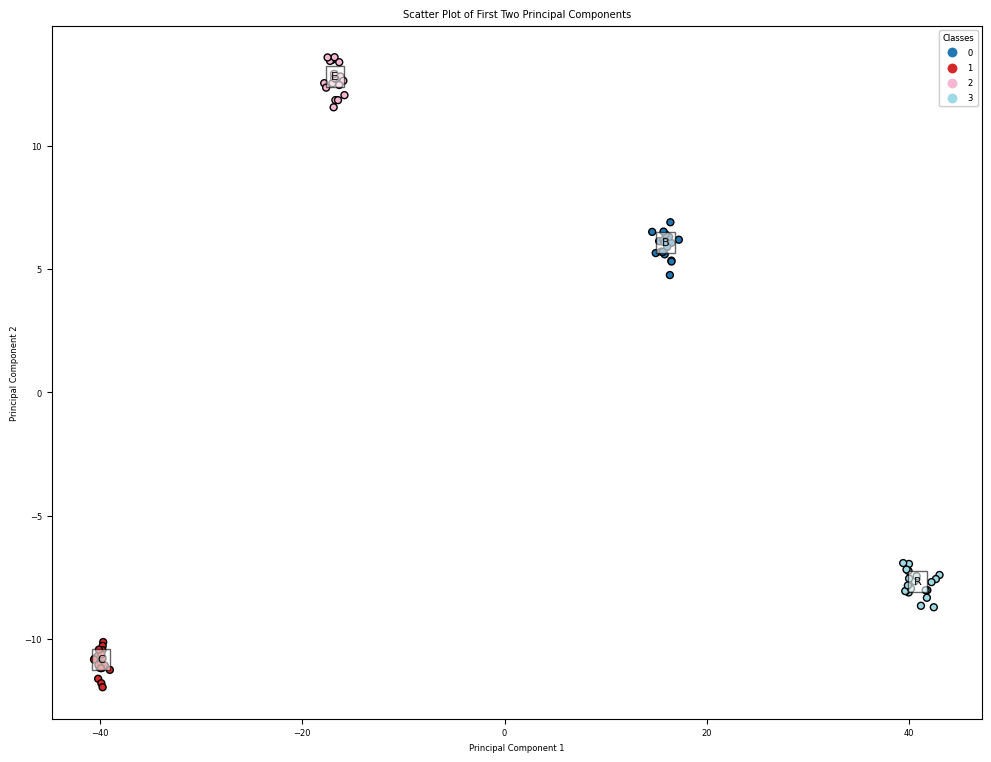

KeyError: '310.0 HG (mV) mean'

<Figure size 1200x900 with 0 Axes>

In [125]:
# Encode the labels
le = LabelEncoder()
y_new_sample_encoded = le.fit_transform(y_new_sample)

# Perform PCA
pca = PCA(n_components=2)
X_new_sample_pca = pca.fit_transform(X_new_sample)

# Create a DataFrame with the PCA components
components = pd.DataFrame(pca.components_, columns=X_new_sample.columns)
components = components.T

# Display the highest and lowest n variables of the first 3 components
n = 10
for i in range(pca.n_components_):
    print(f"Component {i+1}:")
    print(components[i].nlargest(n), '\n')
    print(components[i].nsmallest(n), '\n')

# Plot the PCA components (first two components for visualization)
plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_new_sample_pca[:, 0], X_new_sample_pca[:, 1], c=y_new_sample_encoded, cmap='tab20',
                      edgecolor='k', s=25)
# Produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# Show a class label on the data points (just one label per class in total)
offset = 0.1
unique_labels = np.unique(y_new_sample_encoded)
for i, label in enumerate(unique_labels):
    plt.text(X_new_sample_pca[y_new_sample_encoded == label][:, 0].mean(), 
             X_new_sample_pca[y_new_sample_encoded == label][:, 1].mean() + offset, 
             le.inverse_transform([label])[0], ha='center', va='center', size=8, bbox=dict(facecolor='w', alpha=0.6))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of First Two Principal Components')

plt.show()


# Plot 2 input variables
var1 = '310.0 HG (mV)'
var2 = '360.0 HG (mV)'

var1 = '310.0 HG (mV) mean'
var2 = '360.0 HG (mV) mean'

plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_new_sample[var1], X_new_sample[var2], c=y_new_sample_encoded, cmap='tab20',
                      edgecolor='k', s=25)
# Produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# Show a class label on the data points (just one label per class in total)
offset = 0.1
unique_labels = np.unique(y_new_sample_encoded)

for i, label in enumerate(unique_labels):
    plt.text(X_new_sample[y_new_sample_encoded == label][var1].mean(), 
             X_new_sample[y_new_sample_encoded == label][var2].mean() + offset, 
             le.inverse_transform([label])[0], ha='center', va='center', size=8, bbox=dict(facecolor='w', alpha=0.6))
    
plt.xlabel(var1)
plt.ylabel(var2)
plt.title('Scatter Plot of Chosen Input Variables')

plt.show()




In [83]:
y_pred = rf_model.predict(X_new_sample, y_new_sample_encoded)
y_pred = nb_model.predict(X_new_sample, y_new_sample_encoded)
# y_pred = lr_model.predict(X_new_sample, y_new_sample_encoded)

# Calculate metrics
accuracy = accuracy_score(y_new_sample, y_pred)
precision = precision_score(y_new_sample, y_pred, average='weighted')
recall = recall_score(y_new_sample, y_pred, average='weighted')
f1 = f1_score(y_new_sample, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

# Convert the label encoded values back to the original class names
# y_new_sample = le.inverse_transform(y_new_sample)
# y_pred = le.inverse_transform(y_pred)

# Classification report
print(classification_report(le.inverse_transform(y_new_sample), le.inverse_transform(y_pred)), )

# Predictions made per class with its label encoded value
print(Counter(y_pred))

y_new_sample_encoded = le.inverse_transform(y_new_sample)
y_pred_encoded = le.inverse_transform(y_pred)

plot_confusion_matrix(y_new_sample_encoded, y_pred_encoded, le.classes_)

TypeError: ForestClassifier.predict() takes 2 positional arguments but 3 were given

In [183]:
# Load trained model
rf_model = joblib.load('random_forest_model.pkl')

# Predictions
y_pred = rf_model.predict(X_new_sample)



ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- 100.0 HG (mV) mean
- 100.0 HG (mV) std deviation
- 100.0 LG (mV) mean
- 100.0 LG (mV) std deviation
- 110.0 HG (mV) mean
- ...


## Feature Importance TBD

## Labels

| Original Label | Encoded Value |
|----------------|---------------|
| A1             | 0             |
| B1             | 1             |
| C1             | 2             |
| D1             | 3             |
| E1             | 4             |
| F1             | 5             |
| G1             | 6             |
| H1             | 7             |
| I1             | 8             |
| J1             | 9             |
| K1             | 10            |
| L1             | 11            |
| M1             | 12            |
| N1             | 13            |
| REF            | 14            |